In [1]:
from numpy import *

def loadSimpData():
    datMat = matrix([[1., 2.1],
                    [2., 1.1],
                    [1.3, 1.],
                    [1., 1.],
                    [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [2]:
datMat, classLabels = loadSimpData()

In [3]:
# 单层决策树生成函数
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    """
    单层决策树分类函数
    Parameters:
        dataMatrix - 数据矩阵
        dimen - 第dimen列，也就是第几个特征
        threshVal - 阈值
        threshIneq - 标志
    Returns:
        retArray - 分类结果
    """
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray
    
def buildStump(dataArr, classLabels, D):
    """
    找到数据集上最佳的单层决策树
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        D - 样本权重
    Returns:
        bestStump - 最佳单层决策树信息
        minError - 最小误差
        bestClasEst - 最佳的分类结果
    """
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m, 1)))
    minError = inf # 最小错误率初始化为+∞
    
    for i in range(n):
        rangeMin = dataMatrix[:, i].min(); rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin)/numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']: # 大于和小于阈值的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                # 打印相关信息，可省略
                #print("split: dim %d,thresh %.2f, thresh inequal: %s, the weighted error is %.3f"
                      #% (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst         

In [55]:
D = mat(ones((5,1))/5)

In [56]:
buildStump(datMat, classLabels, D)

split: dim 0,thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0,thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0,thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0,thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0,thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0,thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0,thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0,thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0,thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0,thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0,thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0,thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0,thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0,thresh 1.50, thresh inequ

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [15]:
# 基于单层决策树的AdaBoost训练过程
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)
    aggClassEst = mat(zeros((m,1)))
    
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print("D:", D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16))) # 防止除零溢出，1e-16表示1乘10的-16次方
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print("classEst: ", classEst.T)
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0: break
    
    return weakClassArr, aggClassEst

In [65]:
classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [66]:
classifierArray

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.9}]

In [5]:
# AdaBoost分类函数
def adaClassify(datToClass, classifierArr):
    """
    AdaBoost分类函数
    Parameters:
        datToClass - 待分类样例
        classifierArr - 训练好的分类器
    Returns:
        分类结果
    """
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],
                                classifierArr[i]['thresh'],
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return sign(aggClassEst)

In [6]:
datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [7]:
adaClassify([0, 0], classifierArr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [8]:
adaClassify([[5, 5], [0, 0]], classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

示例：在一个难数据集上应用AdaBoost

In [6]:
# 自适应数据加载函数
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = [] 
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [7]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [11]:
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00194028 0.01134815 0.00151025 0.00488494 0.00256529 0.00111375
  0.00151025 0.00662403 0.00263104 0.00497624 0.00288149 0.00268022
  0.00111375 0.0096568  0.00180826 0.00263104 0.00140834 0.00224421
  0.00268022 0.0072996  0.00497624 0.00111375 0.00151025 0.00168196
  0.00180826 0.00398276 0.00288149 0.00220171 0.00850503 0.00094775
  0.00140834 0.00488494 0.00197654 0.00268022 0.00725458 0.00103859
  0.00479243 0.00791094 0.00151025 0.00479243 0.00103859 0.00398276
  0.00390733 0.00309186 0.00224421 0.00103859 0.01355286 0.00151025
  0.00354571 0.00103859 0.00151025 0.00712147 0.00151025 0.00224421
  0.00354571 0.00662403 0.00224421 0.00383564 0.00249936 0.00103859
  0.00151025 0.00197654 0.00347857 0.00416673 0.00390733 0.00245203
  0.0031422  0.00111375 0.00309186 0.00151025 0.00445768 0.00111375
  0.00479243 0.00364367 0.00850503 0.00488494 0.00138167 0.00094775
  0.00466925 0.00369254 0.00194028 0.00111375 0.00390733 0.00124037
  0.00268022 0.00111375 0.00263104 0.00850503

In [12]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')

In [13]:
prediction10 = adaClassify(testArr, classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [14]:
prediction10

matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 

In [15]:
errorRate = sum(prediction10 != mat(testLabelArr).T) / len(prediction10)

In [16]:
errorRate

0.23880597014925373

In [22]:
# ROC曲线的绘制及AUC计算函数
def plotROC(predStrength, classLabels):
    """
    绘制ROC
    Parameters:
        predStrengths - 分类器的预测强度
        classLabels - 类别
    Returns:
        无
    """
    import matplotlib.pyplot as plt
    cur = (0.0, 0.0)
    ySum = 0.0
    numPosClas = sum(array(classLabels) == 1.0) # 计算正例的数目
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndicies = argsort(predStrength * (-1)) # argsort函数返回的是数组值从小到大的索引值
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep
        else:
            delX = xStep; delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] + delX], [cur[1], cur[1] + delY], c='b')
        cur = (cur[0] + delX, cur[1] + delY)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horese Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)

In [13]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [16]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00229314 0.0098348  0.00178491 0.0042335  0.0022232  0.00131629
  0.00130885 0.00782869 0.00228018 0.00431263 0.00340552 0.00316764
  0.00096522 0.008369   0.00156712 0.00228018 0.00122053 0.00194493
  0.00316764 0.00862712 0.00588122 0.00096522 0.00178491 0.00145766
  0.00213712 0.00345163 0.00340552 0.0019081  0.01005176 0.00082136
  0.00122053 0.0042335  0.00171296 0.00232279 0.0085739  0.00090009
  0.00415333 0.00685597 0.00130885 0.00566399 0.00090009 0.00345163
  0.00461792 0.00267954 0.00194493 0.00090009 0.01601759 0.00130885
  0.00307287 0.00090009 0.00178491 0.00617178 0.00178491 0.00194493
  0.00419054 0.00574068 0.00194493 0.00332414 0.00216605 0.00090009
  0.00178491 0.00171296 0.00301468 0.00361107 0.00461792 0.00289795
  0.00371364 0.00096522 0.00365415 0.00130885 0.00526835 0.00096522
  0.00566399 0.00315777 0.01005176 0.0042335  0.00119742 0.00082136
  0.00404658 0.00436407 0.00168153 0.00096522 0.00461792 0.00107496
  0.00316764 0.00131629 0.00228018 0.01005176

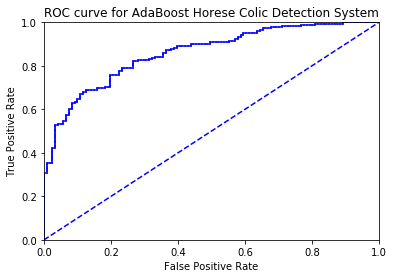

the Area Under the Curve is:  0.8596434209304498


In [23]:
plotROC(aggClassEst.T, labelArr)